In [1]:
import torch
from torch import nn
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)
print(transformers.__version__)

2.0.0+cu118
4.28.0.dev0


In [3]:
import matplotlib as mpl
# default: 100
mpl.rcParams['figure.dpi'] = 200

# text classification

- 也叫 sequence classification
- sentiment analysis
    - 情感分析，就是一种文本/序列分类
        - 电商评论
        - social web：weibo/tweet

## emotions 数据集

In [4]:
from datasets import load_dataset

In [5]:
emotions = load_dataset('emotion')

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/whaow/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# DatasetDict
# 8:1:1
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
emotions.keys()

dict_keys(['train', 'validation', 'test'])

In [8]:
print(emotions['train'], type(emotions['train']))
# 继续支持key
print(emotions['train']['text'][:5])
print(emotions['train']['label'][:5])
# 支持 index
print(emotions['train'][:5])

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
}) <class 'datasets.arrow_dataset.Dataset'>
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']
[0, 0, 3, 2, 3]
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [10]:
print(emotions['train'].features)
print(emotions['train'].features['label'])
print(emotions['train'].features['label'].int2str(3))

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)
anger


In [11]:
labels = emotions['train'].features['label'].names
print(labels)
# 下游任务（downstream task）
num_classes = len(labels)
num_classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


6

In [12]:
def int2str(x):
#     return emotions['train'].features['label'].int2str(x)
    return labels[x]

## data visualization analysis

- dataset => dataframe
- text length 
- label freq

### dataset to dataframe

In [13]:
emotions_df = pd.DataFrame.from_dict(emotions['train'])

In [14]:
print(emotions_df.shape, emotions_df.columns)
emotions_df[:5]

(16000, 2) Index(['text', 'label'], dtype='object')


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [15]:
# emotions_df['label_name'] = emotions_df['label'].apply(lambda x: emotions['train'].features['label'].int2str(x))
emotions_df['label_name'] = emotions_df['label'].apply(lambda x: labels[x])

In [16]:
emotions_df[:5]

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### label analysis

In [17]:
emotions_df.label.value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [18]:
emotions_df.label_name.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label_name, dtype: int64

Text(0.5, 1.0, 'freq of labels')

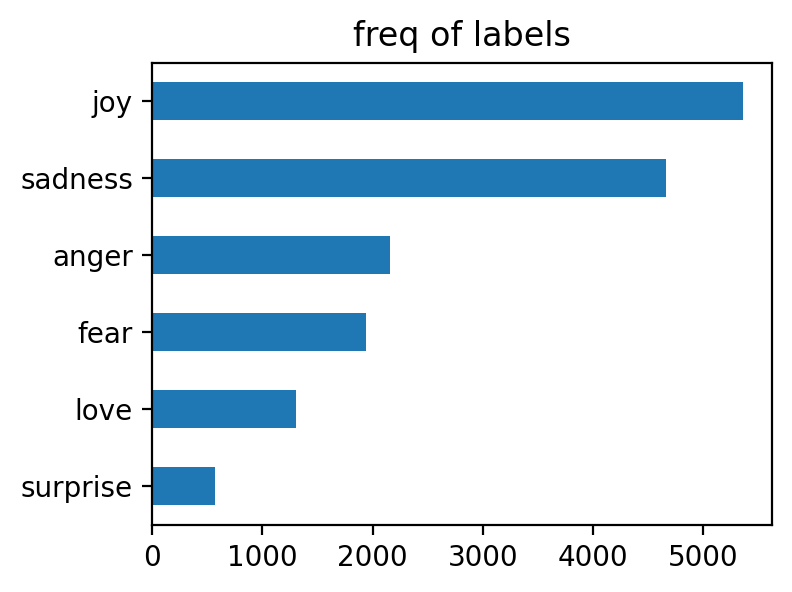

In [19]:
plt.figure(figsize=(4, 3))
emotions_df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('freq of labels')

### text length analysis

Text(0.5, 0, '')

<Figure size 800x600 with 0 Axes>

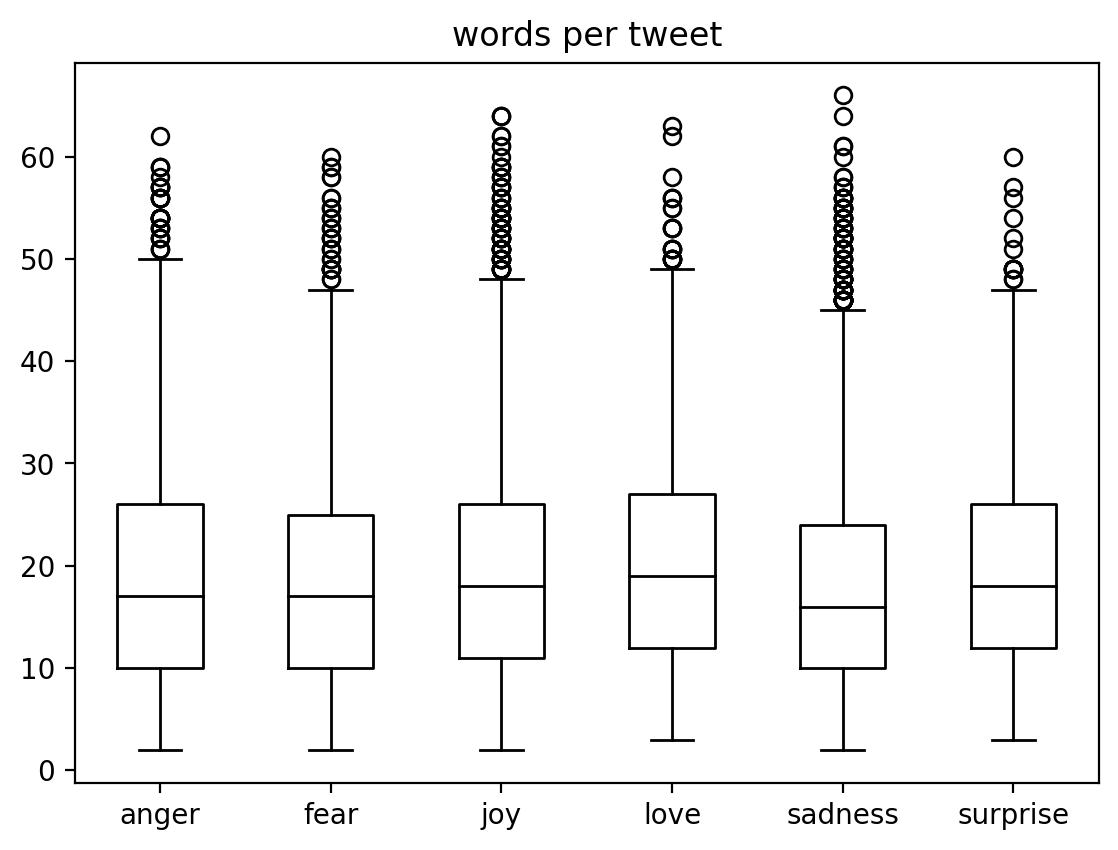

In [21]:
plt.figure(figsize=(4, 3))
emotions_df['words per tweet'] = emotions_df['text'].str.split().apply(len)
emotions_df.boxplot('words per tweet', by='label_name', 
#                     showfliers=False, 
                    grid=False, 
                    color='black')
plt.suptitle('')
plt.xlabel('')

In [22]:
print(emotions_df['words per tweet'].max())
print(emotions_df['words per tweet'].idxmax())

66
6322


In [23]:
print(emotions_df.iloc[6322])
emotions_df.iloc[6322]['text']

text               i guess which meant or so i assume no photos n...
label                                                              0
label_name                                                   sadness
words per tweet                                                   66
Name: 6322, dtype: object


'i guess which meant or so i assume no photos no words or no other way to convey what it really feels unless you feels it yourself or khi bi t au th m i bi t th ng ng i b au i rephrase it to a bit more gloomy context unless you are hurt yourself you will never have sympathy for the hurt ones'

In [24]:
print(emotions_df['words per tweet'].min())
print(emotions_df['words per tweet'].idxmin())

2
4150


In [25]:
emotions_df.iloc[4150]

text               earth crake
label                        4
label_name                fear
words per tweet              2
Name: 4150, dtype: object

## text => tokens

数据集转换为模型接受的输入类型
- Subword Tokenization
    - WordPiece
        - BERT and DistilBERT
- hugging face:
    - `~/.cache/huggingface/`
- tokenizer
    - `tokenizer.vocab_size`
    - model config
        - `tokenizer.model_max_length`
        - `tokenizer.model_input_names`

### tokenizer

In [26]:
from transformers import AutoTokenizer

In [27]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [28]:
# uncased
print(tokenizer.encode('hello world'))
print(tokenizer.encode('HELLO WORLD'))
print(tokenizer.encode('Hello World'))

[101, 7592, 2088, 102]
[101, 7592, 2088, 102]
[101, 7592, 2088, 102]


In [29]:
# 101([CLS]) 开始，以 102 ([SEP]) 结束
tokenizer.encode(emotions_df.iloc[6322]['text'])

[101,
 1045,
 3984,
 2029,
 3214,
 2030,
 2061,
 1045,
 7868,
 2053,
 7760,
 2053,
 2616,
 2030,
 2053,
 2060,
 2126,
 2000,
 16636,
 2054,
 2009,
 2428,
 5683,
 4983,
 2017,
 5683,
 2009,
 4426,
 2030,
 1047,
 4048,
 12170,
 1056,
 8740,
 16215,
 1049,
 1045,
 12170,
 1056,
 16215,
 12835,
 12835,
 1045,
 1038,
 8740,
 1045,
 16360,
 13492,
 3366,
 2009,
 2000,
 1037,
 2978,
 2062,
 24067,
 2100,
 6123,
 4983,
 2017,
 2024,
 3480,
 4426,
 2017,
 2097,
 2196,
 2031,
 11883,
 2005,
 1996,
 3480,
 3924,
 102]

In [30]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


In [31]:
for special_id in tokenizer.all_special_ids:
    print(special_id, tokenizer.decode(special_id))

100 [UNK]
102 [SEP]
0 [PAD]
101 [CLS]
103 [MASK]


### tokenize the whole dataset

In [32]:
def batch_tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [33]:
# batch_tokenize(emotions['train'])
emotions_encoded = emotions.map(batch_tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /home/whaow/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-e7e40ac1a20aaacd.arrow


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Loading cached processed dataset at /home/whaow/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-8b21ce57445713f4.arrow


In [34]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [39]:
print(type(emotions_encoded['train']['input_ids']))
# emotions_encoded['train']['input_ids'][:3]

<class 'list'>


In [40]:
# list to tensor
emotions_encoded.set_format('torch', columns=['label', 'input_ids', 'attention_mask'])

In [43]:
type(emotions_encoded['train']['input_ids'])
# emotions_encoded['train']['input_ids'][:3]

torch.Tensor

# fine-tune transformers

## distilbert-base-uncased

- distilbert 是对 bert 的 distill 而来
    - 模型结构更为简单，
    - bert-base-uncased 参数量：109482240
    - distilbert-base-uncased 参数量：66362880

In [44]:
from transformers import AutoModel
model_ckpt = 'distilbert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt)
model

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [45]:
from transformers_utils import get_params

In [46]:
get_params(model)

66362880

In [47]:
from transformers import AutoModel
model_ckpt = 'bert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt)
get_params(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


109482240

In [48]:
109482240/66362880

1.6497511862053003

In [49]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [50]:
from transformers import AutoModelForSequenceClassification
model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = AutoModelForSequenceClassification.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_classes).to(device)
model

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## trainer

In [51]:
# https://huggingface.co/settings/tokens
# (write)
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/whaow/.cache/huggingface/token
Login successful


In [52]:
# https://huggingface.co/docs/transformers/main_classes/trainer
# https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments
from transformers import TrainingArguments, Trainer

In [53]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_ckpt}_emotion_ft_0416'
training_args = TrainingArguments(output_dir=model_name, 
                                  num_train_epochs=4, 
                                  learning_rate=2e-5,
                                  weight_decay=0.01,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  # write
                                  push_to_hub=True, 
                                  log_level="error")

- trainer默认自动开启 torch 的多gpu模式，
    - `per_device_train_batch_size`: 这里是设置每个gpu上的样本数量，
    - 一般来说，多gpu模式希望多个gpu的性能尽量接近，否则最终多gpu的速度由最慢的gpu决定，
        - 比如快gpu 跑一个batch需要5秒，跑10个batch 50秒，慢的gpu跑一个batch 500秒，则快gpu还要等慢gpu跑完一个batch然后一起更新weights，速度反而更慢了。
    - 同理 `per_device_eval_batch_size` 类似
- `learning_rate`/`weight_decay`
    - 默认使用AdamW的优化算法

In [55]:
from transformers_utils import compute_classification_metrics
trainer = Trainer(model=model, 
                  tokenizer=tokenizer,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  args=training_args, 
                  compute_metrics=compute_classification_metrics)

Cloning https://huggingface.co/lanchunhui/distilbert-base-uncased_emotion_ft_0416 into local empty directory.


In [56]:
trainer.train()

/home/whaow/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision
1,No log,0.426734,0.877000,0.867733,0.877837
2,0.649800,0.212820,0.922000,0.921920,0.897502
3,0.649800,0.188044,0.925000,0.925796,0.887741
4,0.165300,0.171370,0.932500,0.932744,0.902770


/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but al

TrainOutput(global_step=500, training_loss=0.4075119934082031, metrics={'train_runtime': 70.5276, 'train_samples_per_second': 907.446, 'train_steps_per_second': 7.089, 'total_flos': 1440685723392000.0, 'train_loss': 0.4075119934082031, 'epoch': 4.0})

In [57]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output

/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


PredictionOutput(predictions=array([[ 5.321901  , -0.56112975, -0.5788935 , -0.86077183, -1.0296484 ,
        -1.7686785 ],
       [ 5.369429  , -0.719707  , -1.183184  , -0.56268054, -0.7231649 ,
        -1.7755191 ],
       [-0.9560261 ,  2.5084655 ,  3.2520792 , -1.2383951 , -1.5341177 ,
        -1.6156932 ],
       ...,
       [-1.0118183 ,  5.2085857 , -0.22255814, -1.0138346 , -1.5563442 ,
        -1.3893323 ],
       [-1.3537518 ,  3.4339883 ,  2.6796649 , -1.1926656 , -1.7334485 ,
        -1.4770639 ],
       [-1.1767433 ,  5.1086726 , -0.15426004, -1.450834  , -1.5919915 ,
        -0.62788427]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.17136971652507782, 'test_accuracy': 0.9325, 'test_f1': 0.9327439172316551, 'test_precision': 0.9027697506235867, 'test_runtime': 0.6573, 'test_samples_per_second': 3042.753, 'test_steps_per_second': 24.342})

In [58]:
preds_output = trainer.predict(emotions_encoded["validation"])
y_preds = np.argmax(preds_output.predictions, axis=-1)

/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [60]:
y_true = emotions_encoded['validation']['label']

In [61]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

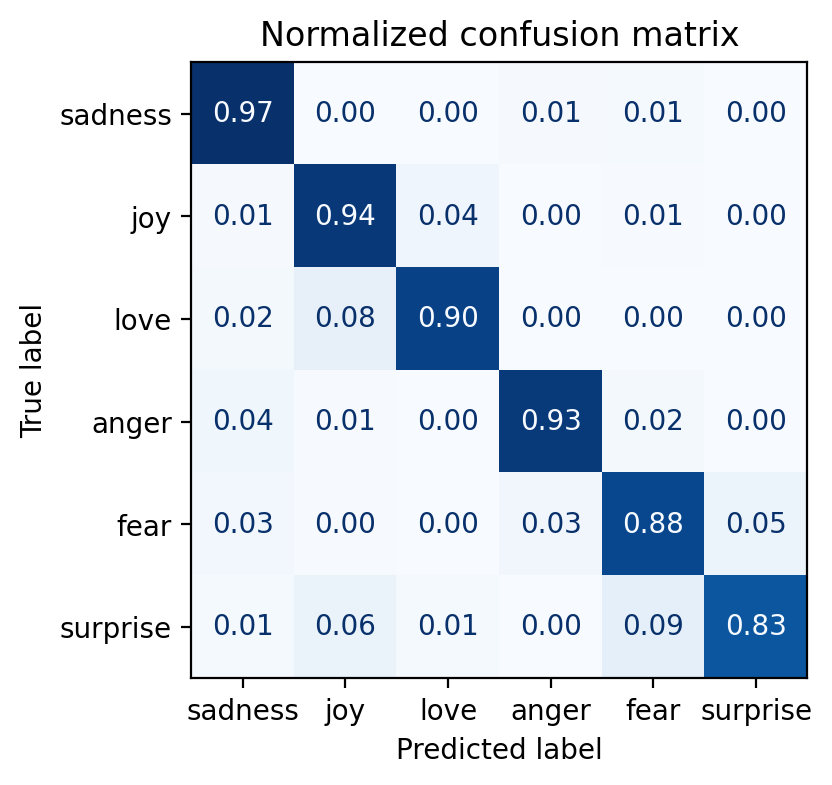

In [62]:
from transformers_utils import plot_confusion_matrix
plot_confusion_matrix(y_preds, y_true, labels)

/home/whaow/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


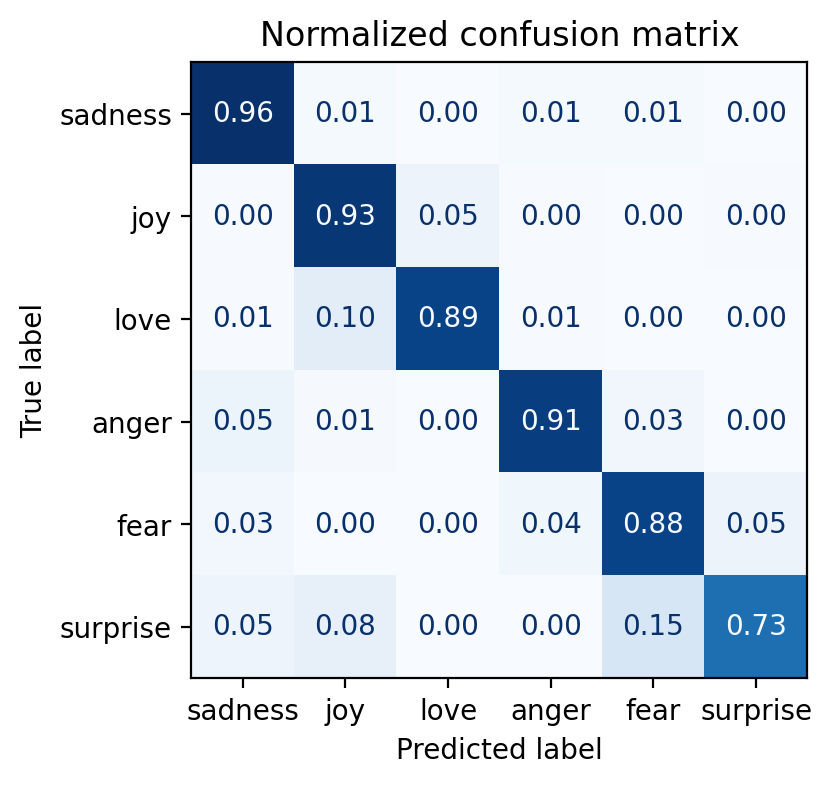

In [63]:
preds_output = trainer.predict(emotions_encoded["test"])
y_preds = np.argmax(preds_output.predictions, axis=-1)
y_true = emotions_encoded["test"]['label']
plot_confusion_matrix(y_preds, y_true, labels)

# result analysis

In [66]:
from torch.nn.functional import cross_entropy

In [67]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [68]:
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [69]:
emotions_encoded['validation']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 2000
})

In [70]:
selected_cols = ['text', 'label', 'predicted_label', 'loss']

In [71]:
valid_df = pd.DataFrame.from_dict({'text': emotions_encoded["validation"]['text'], 
                                   'label': emotions_encoded['validation']['label'].numpy(), 
                                   'pred_label': emotions_encoded['validation']['predicted_label'].numpy(), 
                                   'loss': emotions_encoded["validation"]['loss'].numpy()})
valid_df['label'] = valid_df['label'].apply(lambda x: labels[x])
valid_df['pred_label'] = valid_df['pred_label'].apply(lambda x: labels[x])

In [72]:
valid_df

,text,label,pred_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.010114
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.009351
2,i feel like a faithful servant,love,love,0.417078
3,i am just feeling cranky and blue,anger,anger,0.022240
4,i can have for a treat or if i am feeling festive,joy,joy,0.009649
...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,sadness,0.013275
1996,i constantly worry about their fight against n...,joy,joy,0.011533
1997,i feel its important to share this info for th...,joy,joy,0.010809
1998,i truly feel that if you are passionate enough...,joy,joy,0.406471


In [73]:
valid_df[valid_df['label'] != valid_df['pred_label']]

,text,label,pred_label,loss
17,i know what it feels like he stressed glaring ...,anger,sadness,1.297371
27,i feel as if i am the beloved preparing hersel...,joy,love,1.196154
35,i am feeling very blessed today that they shar...,joy,love,0.952934
55,i didn t feel accepted,joy,love,0.990618
72,i feel that this is important in itself the fa...,joy,sadness,0.784434
...,...,...,...,...
1963,i called myself pro life and voted for perry w...,joy,sadness,6.134463
1964,i feel vaguely cheated and a little amused,joy,anger,3.961156
1981,i spent a lot of time feeling overwhelmed with...,fear,surprise,0.957287
1990,i just feel too overwhelmed i can t see the fo...,fear,surprise,0.980824


In [75]:
1-135/2000

0.9325

In [76]:
# most labels incorrectly
valid_df[valid_df['label'] != valid_df['pred_label']].label.value_counts()

joy         44
fear        25
anger       19
love        17
sadness     16
surprise    14
Name: label, dtype: int64

In [79]:
# 
valid_df.sort_values('loss', ascending=False).head(10)

,text,label,pred_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,6.134463
1950,i as representative of everything thats wrong ...,surprise,sadness,6.044109
882,i feel badly about reneging on my commitment t...,love,sadness,6.040215
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.845109
1111,im lazy my characters fall into categories of ...,joy,fear,5.429384
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.025256
1509,i guess this is a memoir so it feels like that...,joy,fear,4.937392
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.877355
1836,i got a very nasty electrical shock when i was...,fear,anger,4.630801
1683,i had applied for a job and they had assured m...,anger,joy,4.392582


In [80]:
# mislabeld
valid_df.iloc[882].text

'i feel badly about reneging on my commitment to bring donuts to the faithful at holy family catholic church in columbus ohio'

In [82]:
# less loss means more confident
# sadness/joy
valid_df.sort_values('loss', ascending=True).head(20)

,text,label,pred_label,loss
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.008000
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.008075
1873,i feel practically virtuous this month i have ...,joy,joy,0.008261
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.008272
1310,i feel like an ungrateful asshole,sadness,sadness,0.008308
866,i feel quite jaded and unenthusiastic about li...,sadness,sadness,0.008327
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.008341
189,i leave the meeting feeling more than a little...,sadness,sadness,0.008458
1656,im feeling very jaded and uncertain about love...,sadness,sadness,0.008484
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.008497


# to huggingface hub

In [83]:
trainer.push_to_hub(commit_message="Training completed!")

To https://huggingface.co/lanchunhui/distilbert-base-uncased_emotion_ft_0416
   165d1a1..fd9f9fa  main -> main



In [84]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "lanchunhui/distilbert-base-uncased_emotion_ft_0416"
classifier = pipeline("text-classification", model=model_id)

In [88]:
# custom_tweet = "I saw a movie today and it was really good."
custom_tweet = "I saw a movie today and it suck."
preds = classifier(custom_tweet, return_all_scores=True)
preds

/home/whaow/anaconda3/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.2951389253139496},
  {'label': 'LABEL_1', 'score': 0.08960109949111938},
  {'label': 'LABEL_2', 'score': 0.017728755250573158},
  {'label': 'LABEL_3', 'score': 0.40038371086120605},
  {'label': 'LABEL_4', 'score': 0.175038143992424},
  {'label': 'LABEL_5', 'score': 0.022109463810920715}]]

In [86]:
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

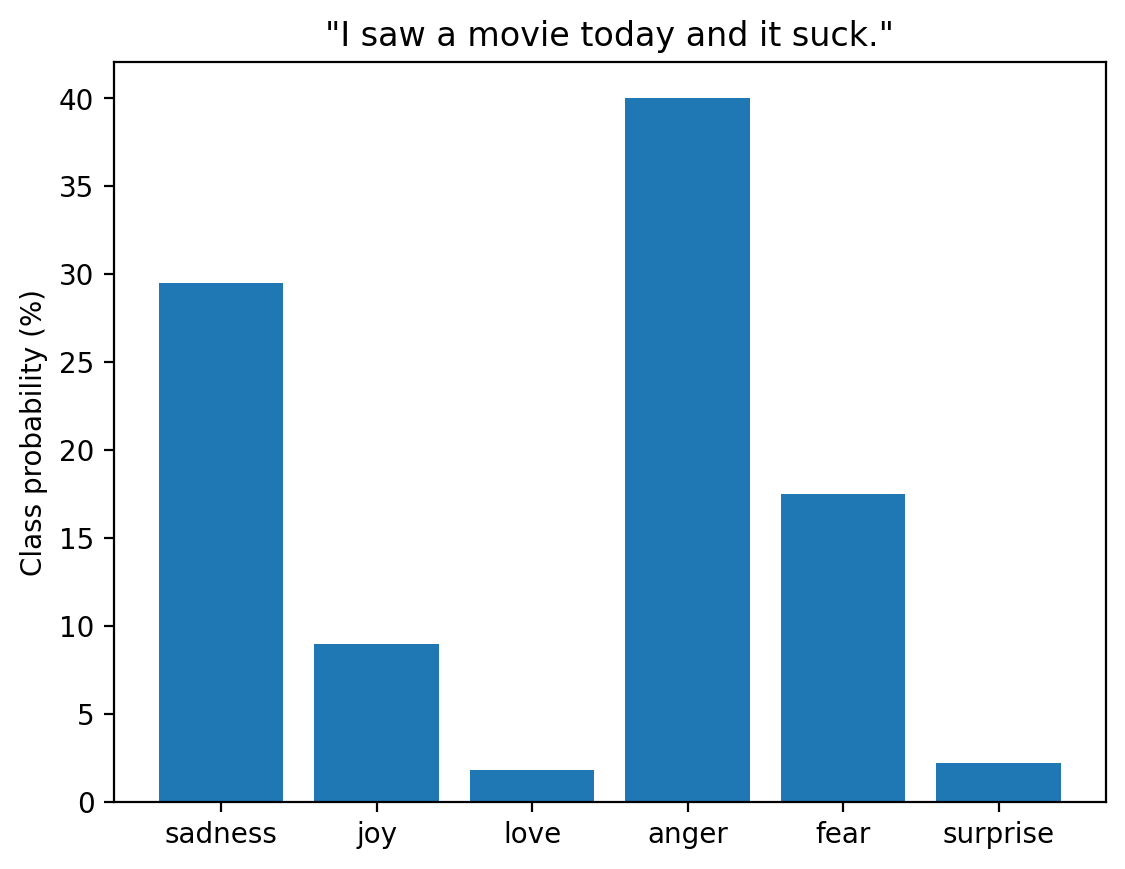

In [89]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()